In [1]:
from __future__ import absolute_import
from __future__ import print_function
from six.moves import xrange
import tensorflow as tf
import numpy as np

import collections
import math
import os
import random
import codecs

In [29]:
with codecs.open('data/wxb_jieba.txt','r','utf-8') as f:
    txtdata =f.read().split()

In [18]:
len(txtdata) # 总词数

1129472

In [19]:
isinstance(txtdata[0], unicode)

True

In [21]:
print txtdata[3] # print 正常显示中文

第一卷


In [12]:
txtdata[2] # 直接显示为 utf-8 编码

u'\u6587\u96c6'

In [30]:
vocabulary_size = 50000 # 假设词典 size

def build_dataset(words):
    count = [[u'未知', -1]]
    # list.extend 延长 list, 不是 append, append 只能加一个元素
    # collections.Counter() 数有多少个 obj, 保存为 dict 形式, unordered
    # most_comment(n)返回 n 个count 数最多的
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1)) # -1 why?
    
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary) # 储存单词, 并编号
    
    data = list()
    unk_count = 0 # 不常见词
    
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else: # 不常见词
            index = 0  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    
    count[0][1] = unk_count
    # 单词和编号倒转
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(txtdata)

In [31]:
len(count)

50000

In [32]:
print '最常见词:'
for i in xrange(10):
    print count[i][0],count[i][1]

print '\n其他词举例:'
for i in xrange(10):
    print count[100+i][0],count[100+i][1]
print '\n样本数据 ', data[0], data[1],data[2],data[3]

最常见词:
未知 9486
， 98787
。 54947
的 48346
我 27858
了 26435
是 16102
在 13448
就 11745
他 11409

其他词举例:
已经 1213
薛嵩 1175
别人 1161
而 1147
一 1138
还是 1137
谁 1131
（ 1103
） 1097
以后 1050

样本数据  6048 1240 3783 24991


标点符号最多....

In [33]:
del txtdata  # Hint to reduce memory.

In [34]:
# 生成 batch 训练集
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index # 前面定义的 =0
    assert batch_size % num_skips == 0 # test condition
    assert num_skips <= 2 * skip_window # ?
    
    batch = np.ndarray(shape=(batch_size), dtype=np.int32) # 按 batch size生成array
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32) #label? 什么 label
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    
    buff = collections.deque(maxlen=span) # deque 类似 list, 但可操作左右两边较自由
    
    for _ in range(span):
        buff.append(data[data_index])
        data_index = (data_index + 1) % len(data) # ?
    
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buff[skip_window]
            labels[i * num_skips + j, 0] = buff[target]
        buff.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [41]:
print 'data:'
for di in data[:8]:
    print reverse_dictionary[di],

data:
目录 王小波 文集 第一卷 杂文 王小波 文集 第二卷


In [43]:
for num_skips, skip_window in [(2,1),(4,2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('batch:', batch)
    print('labels:', labels)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print '    batch:'
    for bi in batch:
        print reverse_dictionary[bi]
    print '    labels:'
    for li in labels.reshape(8):
        print reverse_dictionary[li] 

('batch:', array([ 1240,  1240,  3783,  3783, 24991, 24991,  2772,  2772], dtype=int32))
('labels:', array([[ 3783],
       [ 6048],
       [ 1240],
       [24991],
       [ 2772],
       [ 3783],
       [ 1240],
       [24991]], dtype=int32))

with num_skips = 2 and skip_window = 1:
    batch:
王小波
王小波
文集
文集
第一卷
第一卷
杂文
杂文
    labels:
文集
目录
王小波
第一卷
杂文
文集
王小波
第一卷
('batch:', array([ 3783,  3783,  3783,  3783, 24991, 24991, 24991, 24991], dtype=int32))
('labels:', array([[24991],
       [ 2772],
       [ 1240],
       [ 6048],
       [ 1240],
       [ 3783],
       [ 1240],
       [ 2772]], dtype=int32))

with num_skips = 4 and skip_window = 2:
    batch:
文集
文集
文集
文集
第一卷
第一卷
第一卷
第一卷
    labels:
第一卷
杂文
王小波
目录
王小波
文集
王小波
杂文


In [56]:
# 构建训练模型

batch_size = 128      # 128个词为一组
embedding_size = 128  # Dimension of the embedding vector. 
skip_window = 1       # How many words to consider left and right. 左右各一个作为上下文
num_skips = 2         # How many times to reuse an input to generate a label. 

# validation set 在目标词附近
# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.


graph = tf.Graph()

with graph.as_default():
    # Input data.
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size]) #input 创建占位符
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1]) #labels 占位符
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32) 

    # 用 CPU
    # with tf.device('/cpu:0'):
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        
    
    # construct softmax loss function parameters
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                                                     stddev=1.0/math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    # NCE loss 和 softmax 是一样的吗?
    # Construct the variables for the NCE loss
    #nce_weights = tf.Variable(
    #    tf.truncated_normal([vocabulary_size, embedding_size],
    #                        stddev=1.0 / math.sqrt(embedding_size)))
    #nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Model
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)
    
    # 计算 softmax loss, 每次计算 loss 自动从 negative label 中抽取一个
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed, train_labels,
                                   num_sampled, vocabulary_size))

    # 用 SGD 算法计算loss最小值, learning rate = 1.0
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    # cosine similarity = cos(theta), theta 就是两个向量夹角
    # Compute the cosine similarity between minibatch examples and all embeddings.
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm #normailize
    # validation
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [57]:
valid_examples

array([17, 77, 28, 67,  9, 21, 48, 36, 19, 16, 40, 50, 51, 78,  8, 54])

In [58]:
# 实际开始训练
num_steps = 100001 # 设定循环次数

with tf.Session(graph=graph) as session: # 在 session 中启动
    # We must initialize all variables before we use them.
    tf.initialize_all_variables().run() # 初始化 run
    print("Initialized")

    average_loss = 0
    for step in xrange(num_steps): # 每次循环
        # 先生成 batch
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # 一次只更新一步
        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val # 更新 loss

        # 每2000步 计算一下平均 loss
        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

        # 每1w步 计算相似度
        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval() # 计算 cosine 相似度
            for i in xrange(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors 8个邻居
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log_str = "Nearest to %s:" % valid_word
                for k in xrange(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)
    
    final_embeddings = normalized_embeddings.eval()

Initialized
('Average loss at step ', 0, ': ', 7.2924032211303711)
Nearest to 都: cheese, 积极分子, 间隙, 床框, 抽上来, 南国, 木浆, 感官,
Nearest to 用: 没事人, 率性, 谋逆, 好损, 约定, 反倒, 盐商, 风不动,
Nearest to 一个: 存下, 乘口外, 歇歇, 跪好, 中时, 摇摇头, 仪修, 天比地,
Nearest to 现在: 阅至, 王小波, 夜来, 真叫, 硕士论文, 已然, 花花绿绿, 恶战,
Nearest to 他: 评理, 有碍观瞻, 救救, 面皮, 朝山, 数理化, 车刀, 王国,
Nearest to 上: 与否, 踢倒, 白银, 独舞, 感情投资, 一文不名, 袍服, 更坏,
Nearest to 那: 逃时, 树端, 张得, 不提也罢, 两趟, 装配, 招着, 选中,
Nearest to 着: 下游, 菜窖, 规矩, 队, 奇, 公办, 拨拉, 时要,
Nearest to 把: 一本正经, 细菌, 满脸, 胸中, 低声下气, 有拉碱, 公已, 妇科,
Nearest to 不: 送命, 上边, 无袖, 毛毡, 铁嘴, 他算, 车铃, 臀部,
Nearest to 来: 事时, 接地, 低劣, 咳得, 民风, 清规戒律, 散乱, 假定,
Nearest to 这个: 淹没, 安心, 相会, 攻下, 非礼, 触犯, 手持, 印,
Nearest to 这种: 痕迹, 那块席片, 仪生, 挤进去, 安身之处, 而后, 人和事, 被害,
Nearest to 后来: 烧茶, 转述, 赤色, 形容枯槁, 精神病, 洗, 三圈, 人之患,
Nearest to 就: 芭蕾舞, 适当, 仁人志士, 放火, 造上, 两人动, 十六七岁, 焊工,
Nearest to 时: 另一家, 偏巧, 开了个, 忠实, 查问, 八五年, 未凿, 感情,
('Average loss at step ', 2000, ': ', 4.7652094230651851)
('Average loss at step ', 4000, ': ', 4.1441111403703692)
('Average loss at step ', 60

In [66]:
import sys
sys.getdefaultencoding()

'ascii'

In [67]:
reload(sys)
sys.setdefaultencoding('utf-8')

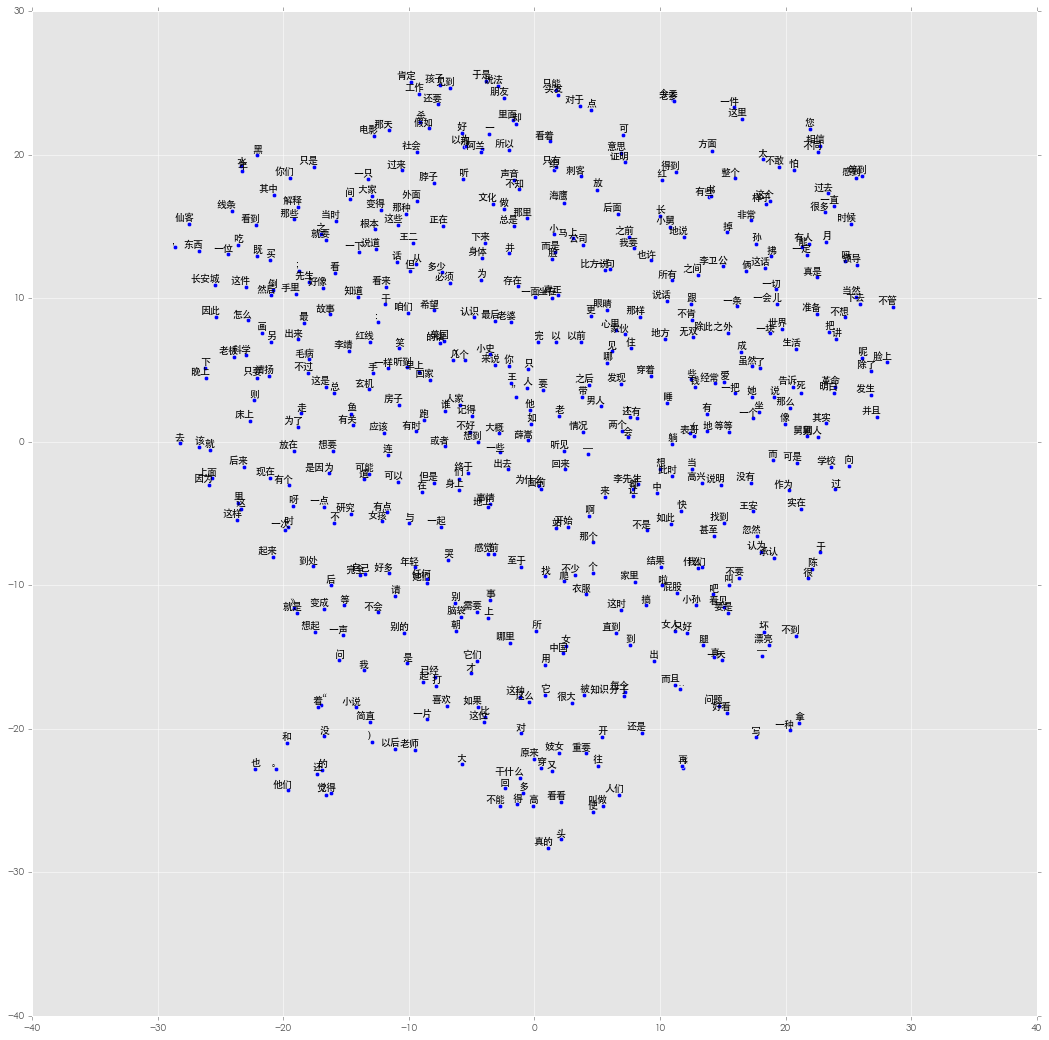

In [69]:
from sklearn.manifold import TSNE # 可视化高维数据工具
import matplotlib
import matplotlib.pyplot as plt
# 在图上需要显示中文 label, 需要设定中文字体
import matplotlib.font_manager as font_manager
font_path = '/Library/Fonts/华文细黑.ttf'
font_prop = font_manager.FontProperties(fname = font_path)
matplotlib.rcParams['font.family'] = font_prop.get_name()
%matplotlib inline
#plt.style.use('ggplot')

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
    plt.show()

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

plot_only = 500 # 只选用500个点
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [reverse_dictionary[i+1] for i in xrange(plot_only)]
plot_with_labels(low_dim_embs, labels)